![alt text](path_to_banner_image.jpg)
# Title
Author: Elijah Lopez

## Overview


## Business Problem


## Data


### Summary of Data Findings


## Potential Routes of Analysis


## Chosen Metrics for Analysis


## Data Cleaning & Feature Engineering

## Analysis

### Direction 1


#### Direction 1 Statistical Testing
Rationale for test selection
H0:
H1:

Recommendation 1:

### Direction 2


#### Direction 2 Statistical Testing
Rationale for test selection
H0:
H1:

Recommendation 2:

### Direction 3

#### Direction 3 Statistical Testing
Rationale for test selection
H0:
H1:

Recommendation 3:

## Results


### Direction 1
* 


### Direction 2
* 


### Direction 3
* 

## Conclusions
This analysis leads to three recommendations.

1. 

2. 

3. 

## Next Steps
* 

## Resources
* [QQQ](https://www.invesco.com/qqq-etf/en/performance.html) - ETF Tracked
* [Yahoo Finance](https://finance.yahoo.com/) - Stock-related data
* [Federal Reserve Economic Data](https://fred.stlouisfed.org/) - Economic-related data
* [Federal Reserve Bank of Minneapolis](https://www.minneapolisfed.org/about-us/monetary-policy/inflation-calculator/consumer-price-index-1913-) - Inflation imputation

In [40]:
# Standard Data Science Toolkit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns
import category_encoders as ce

# Inferential Statistical Tests
from scipy.stats import chi2_contingency, ttest_ind, ttest_rel, f_oneway, pearsonr
from scipy.stats import zscore, norm, binom, poisson
from statsmodels.stats.proportion import proportions_ztest

# Setup to Ignore Version Errors and Deprecations
import warnings
warnings.filterwarnings("ignore")

In [41]:
import yfinance as yf

# Fetch the data
ticker = 'QQQ'
stock_data = yf.download(ticker, start='2000-01-01', end='2023-12-31')

# Reset index and set 'Date' as the new index
stock_data.reset_index(inplace=True)
stock_data.set_index('Date', inplace=True)

# Flatten columns by removing the 'Ticker' level (second level of the MultiIndex)
stock_data.columns = stock_data.columns.get_level_values(0)  # Get the first level, which contains the price types

# Select the relevant columns
stock_data = stock_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

# Remove 'Price' column label
stock_data.columns.name = None

# Display the first few rows
stock_data.head()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,96.1875,96.1875,90.7500,94.75000,80.563759,36345200
2000-01-04,92.0000,93.5000,87.9375,88.25000,75.036949,33786600
2000-01-05,87.5000,89.6250,84.2500,86.00000,73.123825,42496600
2000-01-06,86.8750,88.0000,79.7500,80.09375,68.101913,37134800
2000-01-07,82.9375,90.0000,82.5000,90.00000,76.524940,28138200


In [42]:
stock_data.rename(columns={'Adj Close': 'adj_close'}, inplace=True)
stock_data.columns = stock_data.columns.str.lower()
stock_data.head()

,open,high,low,close,adj_close,volume
Date,,,,,,
2000-01-03,96.1875,96.1875,90.7500,94.75000,80.563759,36345200
2000-01-04,92.0000,93.5000,87.9375,88.25000,75.036949,33786600
2000-01-05,87.5000,89.6250,84.2500,86.00000,73.123825,42496600
2000-01-06,86.8750,88.0000,79.7500,80.09375,68.101913,37134800
2000-01-07,82.9375,90.0000,82.5000,90.00000,76.524940,28138200


In [43]:
stock_data.index.name = stock_data.index.name.lower()
stock_data.head()

,open,high,low,close,adj_close,volume
date,,,,,,
2000-01-03,96.1875,96.1875,90.7500,94.75000,80.563759,36345200
2000-01-04,92.0000,93.5000,87.9375,88.25000,75.036949,33786600
2000-01-05,87.5000,89.6250,84.2500,86.00000,73.123825,42496600
2000-01-06,86.8750,88.0000,79.7500,80.09375,68.101913,37134800
2000-01-07,82.9375,90.0000,82.5000,90.00000,76.524940,28138200


In [44]:
from fredapi import Fred

# Set up FRED API
fred = Fred(api_key='51f2961dd04afe20a0da350a4454eeb6')

# Define FRED series for required economic indicators
series_ids = {
    'interest_rate': 'DFF',            # Federal Funds Rate (%)
    'gdp_growth': 'A191RL1Q225SBEA',   # Real GDP Growth (% change YOY)
    'inflation_rate': 'FPCPITOTLZGUSA',      # Consumer Price Index (% change YOY)
    'unemployment_rate': 'UNRATE',     # Unemployment Rate (%)
    'consumer_sentiment': 'UMCSENT'    # Consumer Sentiment Index (100 = Q1 1966)
}

# Fetch and consolidate data
data = {}
for key, series_id in series_ids.items():
    data[key] = fred.get_series(series_id)

# Combine into a single DataFrame
economic_data = pd.concat(data, axis=1)
economic_data.index.name = 'date'

economic_data.head()

,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
date,,,,,
1947-04-01,NaN,-1.0,NaN,NaN,NaN
1947-07-01,NaN,-0.8,NaN,NaN,NaN
1947-10-01,NaN,6.4,NaN,NaN,NaN
1948-01-01,NaN,6.2,NaN,3.4,NaN
1948-02-01,NaN,NaN,NaN,3.8,NaN


In [45]:
# Inspect date range for overlapping period of QQQ data to see if
# backfilling is reasonable. Because values are reported regularly during this
# time I chose to continue with approach.
overlapping_economic_data = economic_data.loc['2000-01-01' : '2023-12-31']
# overlapping_economic_data     #Scrolled through entire df but commented out for readability
overlapping_economic_data.head()

,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
date,,,,,
2000-01-01,3.99,1.5,3.376857,4.0,112.0
2000-01-02,3.99,NaN,NaN,NaN,NaN
2000-01-03,5.43,NaN,NaN,NaN,NaN
2000-01-04,5.38,NaN,NaN,NaN,NaN
2000-01-05,5.41,NaN,NaN,NaN,NaN


In [ ]:
# Imputed from data from Federal Reserve Bank of Minneapolis
economic_data.loc['2024-01-01', 'inflation_rate'] = 3.2

In [48]:
economic_data.fillna(method='bfill', inplace=True)
economic_data.head()

,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
date,,,,,
1947-04-01,1.13,-1.0,1.457976,3.4,86.2
1947-07-01,1.13,-0.8,1.457976,3.4,86.2
1947-10-01,1.13,6.4,1.457976,3.4,86.2
1948-01-01,1.13,6.2,1.457976,3.4,86.2
1948-02-01,1.13,6.8,1.457976,3.8,86.2


In [60]:
df = stock_data.join(economic_data, how='left', on='date')
df.head()

,open,high,low,close,adj_close,volume,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
date,,,,,,,,,,,
2000-01-03,96.1875,96.1875,90.7500,94.75000,80.563759,36345200,5.43,7.5,2.826171,4.1,111.3
2000-01-04,92.0000,93.5000,87.9375,88.25000,75.036949,33786600,5.38,7.5,2.826171,4.1,111.3
2000-01-05,87.5000,89.6250,84.2500,86.00000,73.123825,42496600,5.41,7.5,2.826171,4.1,111.3
2000-01-06,86.8750,88.0000,79.7500,80.09375,68.101913,37134800,5.54,7.5,2.826171,4.1,111.3
2000-01-07,82.9375,90.0000,82.5000,90.00000,76.524940,28138200,5.61,7.5,2.826171,4.1,111.3


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6037 entries, 2000-01-03 to 2023-12-29
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   open                6037 non-null   float64
 1   high                6037 non-null   float64
 2   low                 6037 non-null   float64
 3   close               6037 non-null   float64
 4   adj_close           6037 non-null   float64
 5   volume              6037 non-null   int64  
 6   interest_rate       6037 non-null   float64
 7   gdp_growth          6037 non-null   float64
 8   inflation_rate      6037 non-null   float64
 9   unemployment_rate   6037 non-null   float64
 10  consumer_sentiment  6037 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 566.0 KB


In [51]:
df.isna().sum()

open                  0
high                  0
low                   0
close                 0
adj_close             0
volume                0
interest_rate         0
gdp_growth            0
inflation_rate        0
unemployment_rate     0
consumer_sentiment    0
dtype: int64

In [52]:
df.describe()

,open,high,low,close,adj_close,volume,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
count,6037.000000,6037.000000,6037.000000,6037.000000,6037.000000,6.037000e+03,6037.000000,6037.000000,6037.000000,6037.000000,6037.000000
mean,114.505493,115.447167,113.474130,114.514999,108.192798,6.855719e+07,1.784827,2.265562,2.553757,5.767302,83.161057
std,101.426111,102.193649,100.608825,101.467618,101.544567,4.925772e+07,1.951698,5.189172,1.624271,1.977136,13.192685
min,19.940001,20.530001,19.760000,20.059999,17.056561,5.212000e+06,0.040000,-28.100000,-0.355546,3.400000,50.000000
25%,41.619999,42.020000,41.240002,41.549999,35.791862,3.274640e+07,0.130000,1.100000,1.622223,4.300000,73.200000
50%,67.470001,68.050003,67.059998,67.379997,60.589108,5.664930e+07,1.120000,2.500000,2.442583,5.200000,84.900000
75%,156.259995,156.720001,155.100006,155.990005,148.909363,8.997810e+07,2.660000,3.500000,3.225944,6.700000,93.500000
max,412.670013,412.920013,410.940002,411.500000,409.728668,6.167723e+08,7.030000,35.200000,8.002800,14.800000,111.300000


Observations:
* Stock price at open, low of the day, high of the day, closing price, and adjusted close follow the general trend of right skew (mean > median) and a wide range of minimum and maximum prices.
* Volume median is roughly 55M and mean is roughly 67M shares traded per day. Range is from 5.2M to 617M.
* Interest rate over this time period is between 0.04% and 7.03% with positive skew.
* GDP ranges from -28% to 35% (each due to the effects of COVID) with the median at 2.5% growth per year.
* Inflation ranges from -0.36% to 8.0% with median and average near 2.5%.
* Unemployment Rate ranges from 3.4-14.8% with mean and median separated by about half a percentage.
* Consumer sentiment is in reference to the stable time period from Q1 1966 (score = 100) with both the mean and the median well below.

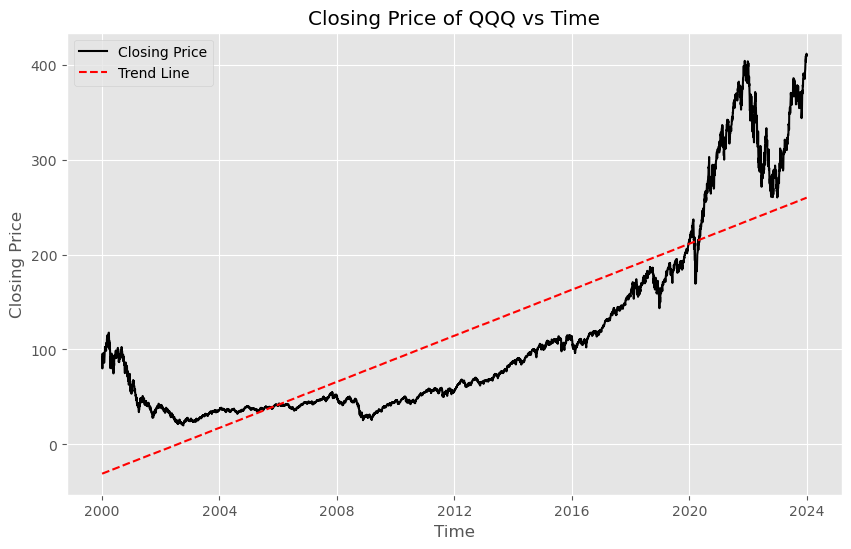

In [53]:
# Graph of QQQ performance over time

# Plot the closing prices
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['close'], label='Closing Price', color='black')

# Fit a linear trend line
x = np.arange(len(df))  # Create an array of from 0 to length of df
y = df['close'].values  # Extract closing prices
trend = np.polyfit(x, y, 1)  # Fit to data
trend_line = np.polyval(trend, x)  # Calculate

# Plot the trend line
plt.plot(df.index, trend_line, label='Trend Line', color='red', linestyle='--')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title(f'Closing Price of {ticker} vs Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

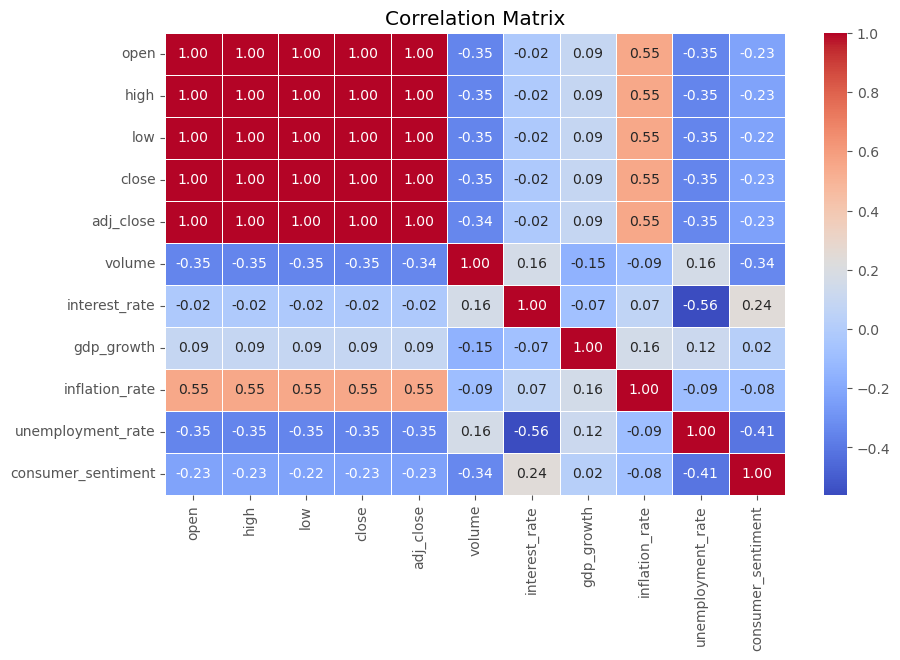

In [54]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Here we see that the only strong correlations relate to the stock-related data.

In [55]:
df.shape

(6037, 11)

In [56]:
df_reduced = df.copy()
df_reduced.drop(columns=['open', 'low', 'high', 'adj_close'], inplace=True)
df_reduced.head()

,close,volume,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
date,,,,,,,
2000-01-03,94.75000,36345200,5.43,7.5,2.826171,4.1,111.3
2000-01-04,88.25000,33786600,5.38,7.5,2.826171,4.1,111.3
2000-01-05,86.00000,42496600,5.41,7.5,2.826171,4.1,111.3
2000-01-06,80.09375,37134800,5.54,7.5,2.826171,4.1,111.3
2000-01-07,90.00000,28138200,5.61,7.5,2.826171,4.1,111.3


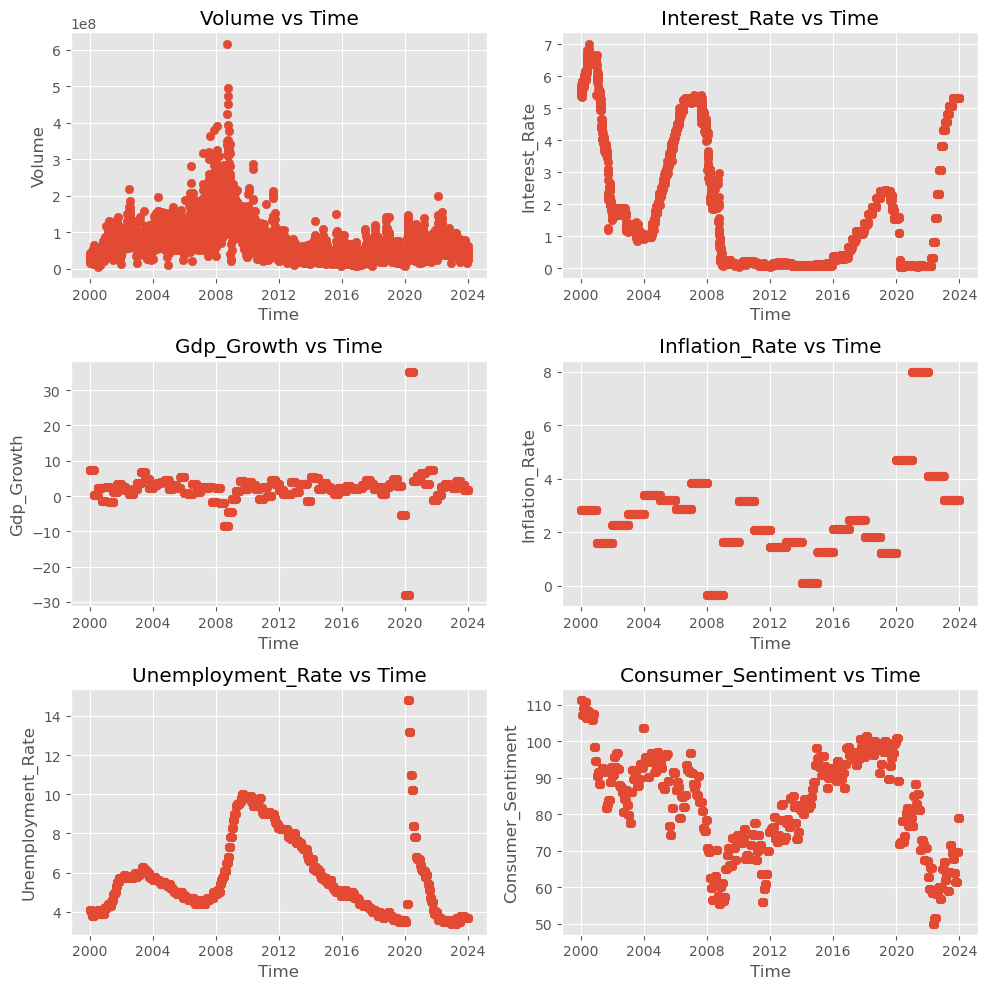

In [57]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
axes = axes.flatten()

for i, column in enumerate(df_reduced.columns):
    if column != 'close':
        ax = axes[i - 1]
        x = df_reduced.index
        y = df_reduced[column]
        ax.scatter(x, y)
        ax.set_title(f'{column.title()} vs Time')
        ax.set_xlabel('Time')
        ax.set_ylabel(column.title())

plt.tight_layout()    

Notes:
* Trading volume peaked around 2009 and has since moderated to approx 100M shares traded per day.
* Interest rate appears semi-cyclic but with irregular period and unequal peaks and troughs.
* GDP growth has remained monstly consistent with notable dips in 2009 (housing crisis) and 2020 (COVID).
* Inflation appears wave-like with recent years with large outlier near 2021.
* Unemployment rate shows peaks around known difficult years and a tapering down to range of roughly 3.5-4.5%.
* Consumer sentiment shows a general decline in sentiment with most notable local minimas in 2009 and 2023 and local maxima in 2019.

In [64]:
df.tail()

,open,high,low,close,adj_close,volume,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
date,,,,,,,,,,,
2023-12-22,409.000000,409.970001,406.480011,408.380005,406.408356,34292400,5.33,1.6,3.2,3.7,79.0
2023-12-26,409.250000,411.559998,409.149994,410.880005,408.896271,22722500,5.33,1.6,3.2,3.7,79.0
2023-12-27,410.950012,411.790009,410.079987,411.500000,409.728668,31980500,5.33,1.6,3.2,3.7,79.0
2023-12-28,412.670013,412.920013,410.940002,411.299988,409.529510,27029200,5.33,1.6,3.2,3.7,79.0
2023-12-29,411.279999,411.640015,407.579987,409.519989,407.757172,42633400,5.33,1.6,3.2,3.7,79.0


In [ ]:
# Determine Compound Annual Growth Rate
initial_close = df.iloc[0]['close']
final_close = df.iloc[-1]['close']
num_years = (df.index[-1] - df.index[0]).days / 365.25

cagr = (final_close/initial_close)**(1/num_years) - 1
cagr

0.06292456783856393

In [80]:
unique_years = df.index.year.unique()
unique_years

Index([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
      dtype='int32', name='date')

In [84]:
unique_months = df.index.month.unique()
unique_months

Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int32', name='date')

In [87]:
monthly_performance = []
for year in unique_years:
    for month in unique_months:
        monthly_data = df.loc[(df.index.year == year) & (df.index.month == month)]

        if not monthly_data.empty:
            initial_monthly_close = monthly_data['close'].iloc[0]
            final_monthly_close = monthly_data['close'].iloc[-1]

            percent_change = ((final_monthly_close - initial_monthly_close) / initial_monthly_close) * 100
            monthly_performance.append({
                'year': year,
                'month': month,
                'percent_change': percent_change
                })

In [ ]:
monthly_performance_df = pd.DataFrame(monthly_performance)
monthly_performance_df.head()

,year,month,percent_change
0,2000,1,-5.343008
1,2000,2,15.914489
2,2000,3,1.742160
3,2000,4,-7.953855
4,2000,5,-13.071895


In [119]:
monthly_median = monthly_performance_df.groupby(by='month')['percent_change'].median()
monthly_median

month
1     0.378224
2    -0.954819
3     0.982713
4     2.622543
5     2.814274
6    -0.350540
7     2.466291
8     1.178457
9    -0.204503
10    4.106686
11    2.568978
12    0.334120
Name: percent_change, dtype: float64

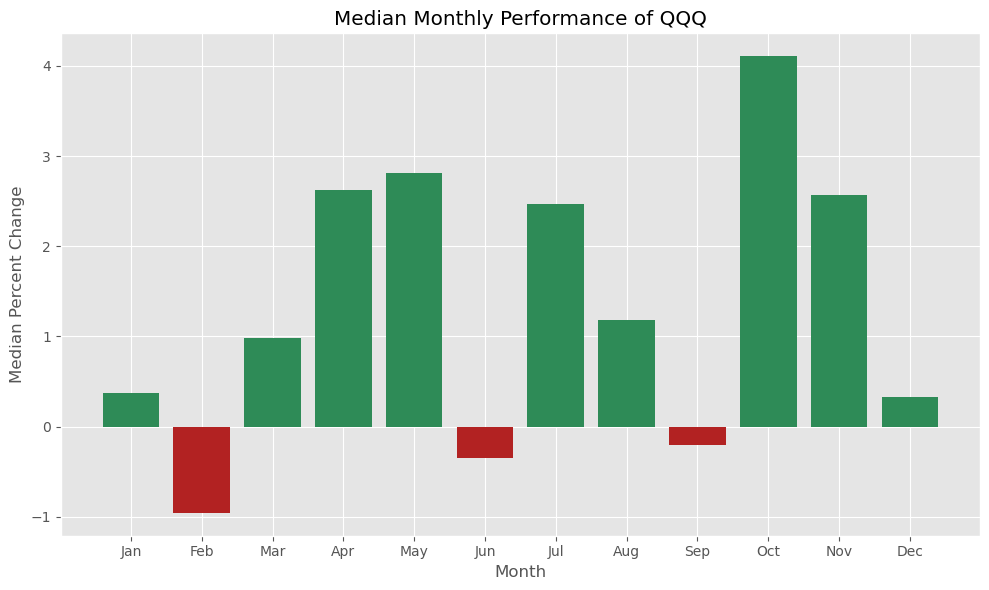

In [118]:
plt.figure(figsize=(10,6))
x = range(len(monthly_median))
y = monthly_median.values

colors = ['#2E8B57' if value > 0 else '#B22222' for value in y]
plt.bar(x, y, color=colors)
plt.title('Median Monthly Performance of QQQ')
plt.xlabel('Month')
plt.xticks(ticks=x , labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Median Percent Change')
plt.tight_layout();

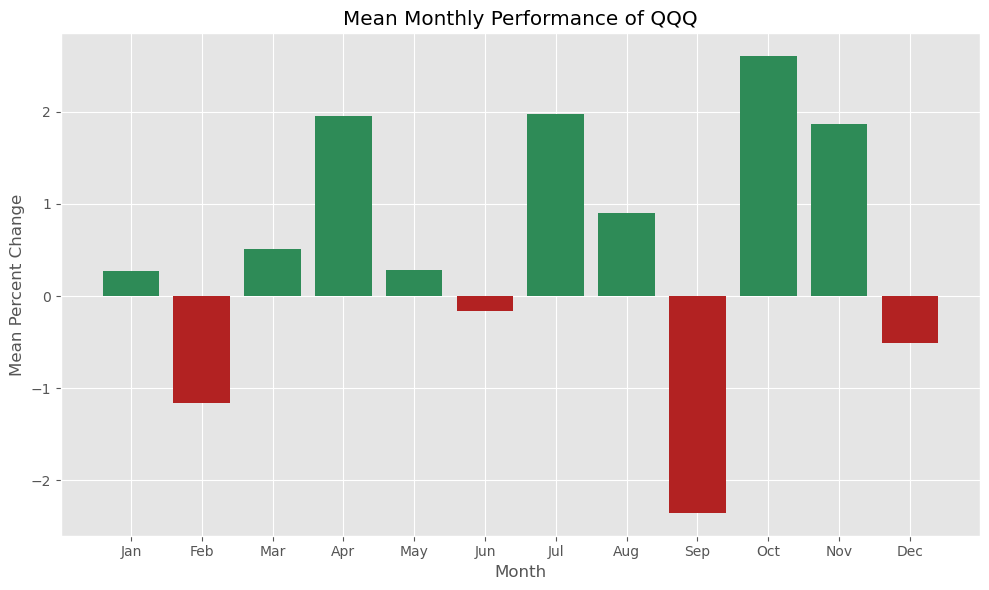

In [122]:
monthly_mean = monthly_performance_df.groupby(by='month')['percent_change'].mean()
plt.figure(figsize=(10,6))
x = range(len(monthly_mean))
y = monthly_mean.values

colors = ['#2E8B57' if value > 0 else '#B22222' for value in y]
plt.bar(x, y, color=colors)
plt.title('Mean Monthly Performance of QQQ')
plt.xlabel('Month')
plt.xticks(ticks=x , labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Mean Percent Change')
plt.tight_layout();